In [1]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.Classify import SklearnClassifier
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
nltk.download('punkt')
nltk.download('popular')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/bryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_rev

True

In [3]:
import timeit

def create_df():
    header = ['id', 'tweet', 'target']

    df = pd.read_csv('sentiment_tweets3.csv', names=header, header=0, encoding='latin-1')

    df = df.drop('id', axis=1)

    return df

timeit.Timer(create_df).timeit(number=1) * 1000



41.84054899997136

# Extract Dataset

In [2]:
header = ['id', 'tweet', 'target']

df = pd.read_csv('sentiment_tweets3.csv', names=header, header=0, encoding='latin-1')
df = df.drop('id', axis=1)

df

,tweet,target
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


In [3]:
df.describe()

,target
count,10314.000000
mean,0.224355
std,0.417177
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


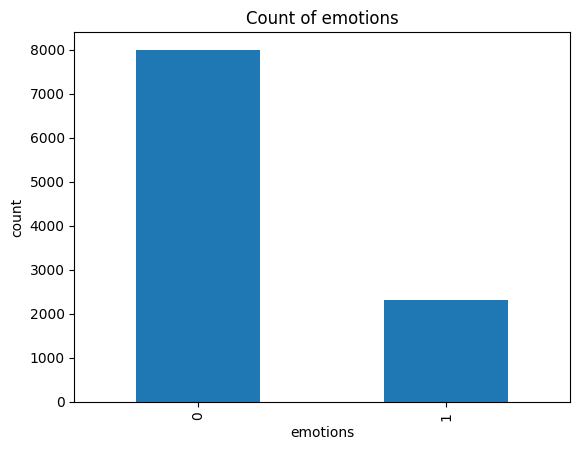

In [4]:
df['target'].value_counts().sort_index().plot(kind='bar', title='Count of emotions')
plt.xlabel("emotions")
plt.ylabel("count")

plt.show()

Taking one of the tweet as an example

In [5]:
example = df['tweet'][2].lower()
print(example)

@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zogfqvh2me8 


## Tokenize words

In [5]:
raw_token = word_tokenize(example)
raw_token

['@',
 'comeagainjen',
 'http',
 ':',
 '//twitpic.com/2y2lx',
 '-',
 'http',
 ':',
 '//www.youtube.com/watch',
 '?',
 'v=zogfqvh2me8']

## Clean Dataset

In [6]:
import string
import re
stopwords = set(nltk.corpus.stopwords.words('english'))

# token = [WordNetLemmatizer().lemmatize(w) for w in stopwords_removed_token]

def clean_words(words):
    table = str.maketrans('', '', string.punctuation)
    splitted_words = words.split()

    lower_split = [w for w in splitted_words if "@" not in w]
    lower_split = [w for w in lower_split if "#" not in w]
    lower_split = [w for w in lower_split if "http" not in w]
    
    lower_split = [w.strip() for w in lower_split]
    lower_split = [w for w in lower_split if not w.isdigit()]
    lower_split = [w for w in lower_split if w.isalpha()]

    lower_split = [w.translate(table) for w in lower_split]

    stopwords_removed_token = [w for w in lower_split if not w in stopwords]
    token = [PorterStemmer().stem(w) for w in stopwords_removed_token]

    token = " ".join(str(x) for x in token)
    return token

df['tweet'] = df['tweet'].apply(lambda x: clean_words(x))

df.head(10)

,tweet,target
0,real good missssssssss,0
1,read manga,0
2,,0
3,need send account i even refer those support,0
4,add me on,0
5,good time tonight though,0
6,someon alreadi fiber home mean least regular,0
7,possibl nice,0
8,nite twittervil workout,0
9,sweet dream,0


# Splitting data for testing and training

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df['tweet'], df['target'], test_size=0.3, random_state=100, shuffle=True)

# MNB

In [8]:
count_vect = CountVectorizer()
count_mnb_clf = Pipeline([
    ('count_vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

count_mnb_clf.fit(x_train, y_train)

Pipeline(steps=[('count_vect', CountVectorizer()), ('clf', MultinomialNB())])

In [24]:
cv_result = cross_validate(count_mnb_clf, x_test, y_test, scoring=['f1', 'recall', 'accuracy', 'precision', 'neg_log_loss', 'balanced_accuracy'], cv=6)
print(cv_result['test_f1'].mean())
print(cv_result['test_recall'].mean())
print(cv_result['test_accuracy'].mean())
print(cv_result['test_precision'].mean())
print(cv_result['test_neg_log_loss'].mean())
print(cv_result['test_balanced_accuracy'].mean())

cv_result

0.8850492173709478
0.8777343184122847
0.9483078698477209
0.8931816253973586
-0.18164683896162034
0.9233992599773332


{'fit_time': array([0.05794191, 0.05178642, 0.05169654, 0.05580115, 0.04767656,
        0.04863119]),
 'score_time': array([0.03424931, 0.03641629, 0.03357577, 0.03380299, 0.03414464,
        0.03415012]),
 'test_f1': array([0.88235294, 0.87445887, 0.88      , 0.90677966, 0.85217391,
        0.91452991]),
 'test_recall': array([0.8974359 , 0.86324786, 0.84615385, 0.91452991, 0.83050847,
        0.91452991]),
 'test_accuracy': array([0.94573643, 0.94379845, 0.94767442, 0.95736434, 0.93410853,
        0.96116505]),
 'test_precision': array([0.8677686 , 0.88596491, 0.91666667, 0.89915966, 0.875     ,
        0.91452991]),
 'test_neg_log_loss': array([-0.17912175, -0.20564058, -0.18158107, -0.15392093, -0.21187963,
        -0.15773708]),
 'test_balanced_accuracy': array([0.92866782, 0.9153332 , 0.91179873, 0.94222736, 0.8976663 ,
        0.94470214])}

## Learning Curve

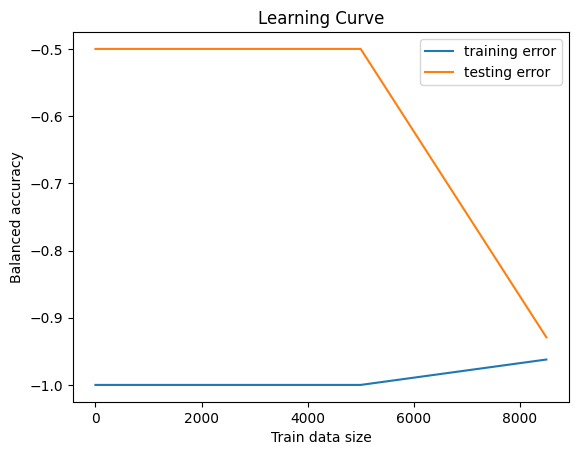

In [28]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
import numpy as np

train_sizes = [1, 1000, 3000, 5000, 8500]
# print(np.linspace(1, 45000, 100))
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator=count_mnb_clf, X=np.asarray(df['tweet']), y=np.asarray(df['target']), train_sizes=train_sizes, cv=6, scoring='balanced_accuracy', random_state=100, return_times=True)
plt.plot(train_sizes, np.mean(-train_scores,axis=1), label='training error')
plt.plot(train_sizes, np.mean(-test_scores,axis=1), label='testing error')
plt.xlabel("Train data size")
plt.ylabel("Balanced accuracy")
plt.title("Learning Curve")
plt.legend()

# SVC

In [21]:
count_vect = CountVectorizer()
count_svc_pipeline = Pipeline([
    ('count_vect', CountVectorizer()),
    ('clf', SVC())
])

count_svc_pipeline.fit(x_train, y_train)

Pipeline(steps=[('count_vect', CountVectorizer()), ('clf', SVC())])

In [23]:
cv_result = cross_validate(count_svc_pipeline, x_test, y_test, scoring=['f1', 'recall', 'accuracy', 'precision', 'balanced_accuracy'], cv=6)

print(cv_result['test_f1'].mean())
print(cv_result['test_recall'].mean())
print(cv_result['test_accuracy'].mean())
print(cv_result['test_precision'].mean())
print(cv_result['test_balanced_accuracy'].mean())

cv_result

0.844019139078534
0.734076971365107
0.9386148114698578
0.994392684610076
0.8664119192665135


{'fit_time': array([0.77146816, 0.73599982, 0.53756356, 0.38043737, 0.36235118,
        0.35239244]),
 'score_time': array([0.12688851, 0.13055587, 0.06396198, 0.0643785 , 0.06338477,
        0.06095719]),
 'test_f1': array([0.85853659, 0.83      , 0.82587065, 0.86124402, 0.80808081,
        0.88038278]),
 'test_recall': array([0.75213675, 0.70940171, 0.70940171, 0.76923077, 0.6779661 ,
        0.78632479]),
 'test_accuracy': array([0.94379845, 0.93410853, 0.93217054, 0.94379845, 0.92635659,
        0.95145631]),
 'test_precision': array([1.        , 1.        , 0.98809524, 0.97826087, 1.        ,
        1.        ]),
 'test_balanced_accuracy': array([0.87606838, 0.85470085, 0.85344772, 0.88210912, 0.83898305,
        0.89316239])}

## Learning Curve

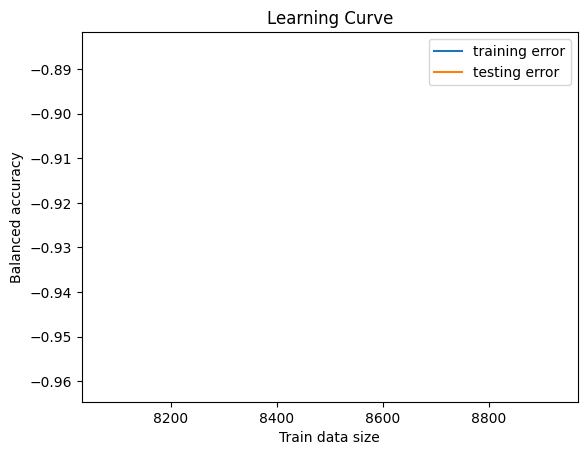

In [35]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
import numpy as np

train_sizes = [1, 1000, 3000, 5000, 8500]
# print(np.linspace(1, 45000, 100))
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator=count_svc_pipeline, X=np.asarray(df['tweet']), y=np.asarray(df['target']), train_sizes=train_sizes, cv=6, scoring='balanced_accuracy', random_state=100, return_times=True)
plt.plot(train_sizes, np.mean(-train_scores,axis=1), label='training error')
plt.plot(train_sizes, np.mean(-test_scores,axis=1), label='testing error')
plt.title("Learning Curve")
plt.xlabel("Train data size")
plt.ylabel("Balanced accuracy")
plt.legend()

# Random Forest Classifier

In [10]:
count_vect = CountVectorizer()
count_rf_pipeline = Pipeline([
    ('count_vect', CountVectorizer()),
    ('clf', RandomForestClassifier())
])

count_rf_pipeline.fit(x_train, y_train)

Pipeline(steps=[('count_vect', CountVectorizer()),
                ('clf', RandomForestClassifier())])

In [32]:
cv_result = cross_validate(count_rf_pipeline, x_test, y_test, scoring=['f1', 'recall', 'accuracy', 'precision', 'balanced_accuracy'], cv=6)

print(cv_result['test_f1'].mean())
print(cv_result['test_recall'].mean())
print(cv_result['test_accuracy'].mean())
print(cv_result['test_precision'].mean())
print(cv_result['test_balanced_accuracy'].mean())

cv_result

0.8783928843333816
0.7881114491283983
0.9505669702215198
0.9928949357520787
0.8932182036261759


{'fit_time': array([1.11988807, 0.95677876, 1.03242755, 1.12406158, 1.12584352,
        1.13100648]),
 'score_time': array([0.06742239, 0.0503304 , 0.07480812, 0.05945277, 0.05960512,
        0.06790805]),
 'test_f1': array([0.90654206, 0.86407767, 0.86956522, 0.89099526, 0.84615385,
        0.89302326]),
 'test_recall': array([0.82905983, 0.76068376, 0.76923077, 0.8034188 , 0.74576271,
        0.82051282]),
 'test_accuracy': array([0.96124031, 0.94573643, 0.94767442, 0.95542636, 0.9379845 ,
        0.95533981]),
 'test_precision': array([1.        , 1.        , 1.        , 1.        , 0.97777778,
        0.97959184]),
 'test_balanced_accuracy': array([0.91452991, 0.88034188, 0.88461538, 0.9017094 , 0.87036879,
        0.90774385])}

## Learning Curve

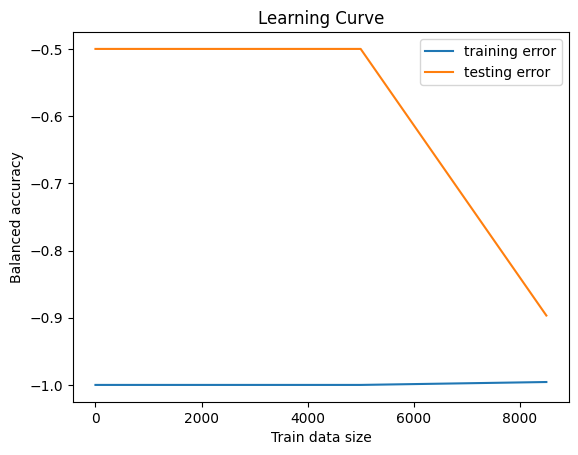

In [36]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
import numpy as np

train_sizes = [1, 1000, 3000, 5000, 8500]
# print(np.linspace(1, 45000, 100))
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator=count_rf_pipeline, X=np.asarray(df['tweet']), y=np.asarray(df['target']), train_sizes=train_sizes, cv=6, scoring='balanced_accuracy', random_state=100, return_times=True)
plt.plot(train_sizes, np.mean(-train_scores,axis=1), label='training error')
plt.plot(train_sizes, np.mean(-test_scores,axis=1), label='testing error')
plt.title("Learning Curve")
plt.xlabel("Train data size")
plt.ylabel("Balanced accuracy")
plt.legend()

# Word Tagging

In [75]:
tag = nltk.pos_tag(token)
tag

[('@', 'JJ'),
 ('kal_penn', 'VB'),
 ('pretty', 'RB'),
 ('much', 'JJ'),
 ('fave', 'VBP'),
 ('...', ':'),
 ('much', 'JJ'),
 ('reason', 'NN'),
 ('watch', 'NN')]

chunking the tag

In [76]:
chunk = nltk.chunk.ne_chunk(tag)
chunk.pprint()
# chunk.draw()

# chunkGram = r"""Chunk: {<RB.?>*<VB.?>*<NNP><NN>?}"""
# chunkParser = nltk.RegexpParser(chunkGram)
# chunked = chunkParser.parse(tag)
# chunked

(S
  @/JJ
  kal_penn/VB
  pretty/RB
  much/JJ
  fave/VBP
  .../:
  much/JJ
  reason/NN
  watch/NN)


In [77]:
sia = SentimentIntensityAnalyzer()
res = {}
for i, row in df.iterrows():
    tweet = row['tweet']
    Id = row['id']
    res[Id] = sia.polarity_scores(tweet)

polarity_score = sia.polarity_scores(x)

plt.bar(list(polarity_score.keys()), list(polarity_score.values()))
plt.show()

KeyboardInterrupt: 

# Vader

In [98]:
vaders = pd.DataFrame(res)
# vaders = vaders.reset_index().rename(columns={'index': 'id'})
# vaders = vaders.merge(df, how='left')
vaders.head(10)

,1467810369,1467810672,1467810917,1467811184,1467811193,1467811372,1467811592,1467811594,1467811795,1467812025,...,2193579249,2193579284,2193579434,2193579477,2193579489,2193601966,2193601969,2193601991,2193602064,2193602129
neg,0.1290,0.303,0.0000,0.321,0.2410,0.0,0.0000,0.093,0.0,0.0,...,0.0,0.1690,0.0,0.0,0.0000,0.1380,0.0000,0.0000,0.0000,0.0000
neu,0.7450,0.697,0.8330,0.500,0.7590,1.0,0.2440,0.548,1.0,1.0,...,1.0,0.8310,1.0,1.0,0.7240,0.5030,0.7570,0.8000,0.7060,0.5190
pos,0.1260,0.000,0.1670,0.179,0.0000,0.0,0.7560,0.359,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.2760,0.3580,0.2430,0.2000,0.2940,0.4810
compound,-0.0173,-0.750,0.4939,-0.250,-0.6597,0.0,0.4767,0.745,0.0,0.0,...,0.0,-0.6467,0.0,0.0,0.7906,0.5423,0.4376,0.3612,0.6784,0.5719


In [42]:
tweets_neg_token = []
tweets_pos_token = []

for i, row in df.iterrows():
    row['tweet'] = row
    if row['target'] == 0:
        tweets_neg_token.extend(word_tokenize(row['tweet']))
    elif row['target'] == 4:
        tweets_pos_token.extend(word_tokenize(row['tweet']))

all_neg_words = nltk.FreqDist(tweets_neg_token)
print(all_neg_words)

<FreqDist with 474557 samples and 13289587 outcomes>


In [41]:
word_features = list(all_words.keys())[:4800000]
word_features

['@',
 'switchfoot',
 'http',
 ':',
 '//twitpic.com/2y1zl',
 '-',
 'Awww',
 ',',
 'that',
 "'s",
 'a',
 'bummer',
 '.',
 'You',
 'shoulda',
 'got',
 'David',
 'Carr',
 'of',
 'Third',
 'Day',
 'to',
 'do',
 'it',
 ';',
 'D',
 'is',
 'upset',
 'he',
 'ca',
 "n't",
 'update',
 'his',
 'Facebook',
 'by',
 'texting',
 '...',
 'and',
 'might',
 'cry',
 'as',
 'result',
 'School',
 'today',
 'also',
 'Blah',
 '!',
 'Kenichan',
 'I',
 'dived',
 'many',
 'times',
 'for',
 'the',
 'ball',
 'Managed',
 'save',
 '50',
 '%',
 'The',
 'rest',
 'go',
 'out',
 'bounds',
 'my',
 'whole',
 'body',
 'feels',
 'itchy',
 'like',
 'its',
 'on',
 'fire',
 'nationwideclass',
 'no',
 'not',
 'behaving',
 'at',
 'all',
 'i',
 "'m",
 'mad',
 'why',
 'am',
 'here',
 '?',
 'because',
 'see',
 'you',
 'over',
 'there',
 'Kwesidei',
 'crew',
 'Need',
 'hug',
 'LOLTrish',
 'hey',
 'long',
 'time',
 'Yes',
 '..',
 'Rains',
 'bit',
 'only',
 'LOL',
 'fine',
 'thanks',
 'how',
 'Tatiana_K',
 'nope',
 'they',
 'did',
 '